<a href="https://colab.research.google.com/github/AcuSilas/Health-Fusion/blob/main/Health_Fusion_NoteBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  ANALYSIS OF THE HEALTHCARE ACCESSIBILITY IN NAIROBI

## Objective
Understanding the relationship between **population characteristics** and **healthcare access** in **`Nairobi County`**. This analysis will help identify gaps in healthcare provision, inform policy decisions, and improve the allocation of resources.

###  Key aspects involved in this analysis:
- Cleaning the data
- Descriptive Statistics and Visualization
- Spatial Analysis
- Comparative Analysis

#### STEP 1: DATA CLEANING
The e-health Kenya facilities data was the dataset that needed cleaning and preparation. This was done via excel sheet.
The following steps were followed to produce a dataset that is usable and consistent:
1. Filtered the data to remain with healthcare facilities located in Nairobi
2. Removed all the empty columns in the dataset
3. The columns indicating certain services such as ART (Antiretroviral Therapy),C-IMCI (Community Integrated Management of Childhood Illnesses)	,FP (Family Planning),HBC (Hospital-Based Care) and IPD (In-Patient Department) all had the same value of y(yes) indicating they were all available in all the facilities. They were combined to be under a column named 'Common_Services'
4. Since we are focusing on data from Nairobi county/province, the related columns were deleted
5. The 'In Charge' column indicating names of the people incharge was deleted as their names were unnecessary in this case.
6. The 'Job Title of in Charge' column was simplified by replacing 'Doctor in Charge' and 'Nursing Officer in Charge' with 'Doctor' and 'Nursing Officer' respectively.
7. The 'District' column had same values as the 'Constituency' column leading to the district column being deleted.
8. The following columns were also deleted since they would not be useful in our analysis: 'Division', 'Location', 'Sublocation', 'Nearest Town' and 'Description of location'.
9. The most commonly used contact methods are typically email and mobile numbers thus those were the columns that were retained
10. The 'Official Mobile' column had blank and zero values. This values were filtered out and it was noticed that some of them had a number in the 'Official Alternate No'. Therefore the blanks/zeros were replaced by this alternative number where applicable.There were also discrepancies in the phone number format which was cleaned up for uniformity
11. Zeros and blanks in the email column were replaced with null

After the process above, the dataset was ready for Exploratory Data Analysis (EDA)

Link to the datasets

Cleaned Population Dataset link
https://github.com/AcuSilas/Health-Fusion/blob/main/cleaned_Nairobi_population.xlsx

Cleaned Nairobi healthcare dataset link
https://github.com/AcuSilas/Health-Fusion/blob/main/nairobi_healthcare_data.xlsx

In [21]:
# Loading the libraries required for the exercise
#Data Analysis
import pandas as pd
import numpy as np

#Spatial Analysis
import osmnx
from scipy.spatial import cKDTree
import geopandas as gpd
from scipy.interpolate import griddata

#Visualization
import matplotlib.pyplot as plt
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px
import seaborn as sns

# Load datasets
df_healthcare = pd.read_excel('/content/nairobi_healthcare_data.xlsx')
df_population = pd.read_excel('/content/cleaned_Nairobi_population.xlsx')
health_fac = gpd.read_file('/content/health_facilities.gpkg')
barriers = gpd.read_file('/content/other_features.shp')
sub_counties = gpd.read_file('/content/sub_county_boundary.gpkg')
county_boundary = gpd.read_file('/content/county_boundary.gpkg')
study_area_data = gpd.read_file('/content/random_points.gpkg')
places = gpd.read_file('/content/places.shp')

In [7]:
df_healthcare.head(5)

,Facility Code,Facility Name,Type,Owner,Constituency,Beds,Cots,Official Mobile,Official Email,Job Title of in Charge,Open 24 Hours,Open Weekends,Operational Status,"Common_services(ART,C-IMCI,FP,HBC,IPD)"
0,12861,AAR City Centre Clinic,Medical Clinic,Private Enterprise (Institution),STAREHE,0,0,731191077,emutugi@aar.co.ke,Doctor,N,Y,Operational,Y
1,12862,AAR Kariobangi Clinic,Medical Clinic,Private Enterprise (Institution),RUARAKA,0,0,729876092,info@aar.co.ke,Nursing Officer,N,N,Not-Operational,Y
2,12863,AAR Thika Road Clinic,Medical Clinic,Private Enterprise (Institution),ROYSAMBU,0,0,712509222,ckidiga@gmail.com,Medical Superintendant,N,N,Operational,Y
3,12864,Abandoned Child Care,Dispensary,Non-Governmental Organizations,DAGORETTI SOUTH,0,0,712509222,abakoredispensary@yahoo.com,Nursing Officer,N,N,Operational,Y
4,12865,Afwan Medical Centre,Nursing Home,Private Enterprise (Institution),KAMUKUNJI,40,4,723937630,afwanmedical@gmail.com,Hospital Director,Y,Y,Operational,Y


#### Step 2: Exploratory Data Analysis (EDA)
During the Exploratory Data Analysis (EDA) phase, our main objective is to gain a preliminary understanding of the dataset's characteristics, identify patterns, and uncover insights that can guide further analysis.
To do this, the following questions need to be asked:
1. What type of medical facilities are there in Nairobi? What level do they fall under?
2. What is the operational status of these facilities?
3. Who owns these medical facilities? How does ownership affect the affordability of healthcare?
4. What is the  adult and pediatric capacity? What is total capacity  of these facilities?  
5. How available are the services offered by these facilities? Are they open 24/7 or throughout the week?
6. What are the least and most common services offered by these facilities?
7. How are these facilities distributed across Nairobi's constituencies?
8. How does the distribution of the facilities compare to the population of people being served? Are there underserved areas in Nairobi?
9. How does these facilities correlate with population demographics like age and income level? Are there demographics facing more challenges?
10. What policies should be implemented to address identified challenges?

## 1. Types of Medical Facilities in Nairobi and Their Levels
Understanding the variety and classification of medical facilities in Nairobi is essential for assessing healthcare accessibility and quality. This section explores the different types of medical facilities available in Nairobi and categorizes them into levels based on their scope of services and capacity.

### Explanation and Implications of Health Facility Classifications

### Level 1: Community Health Services
**Focus**: Primary health care and preventive services at the community level.  
**Example Services**: Basic health education, immunizations, and preventive health care.

### Level 2: Dispensaries and Clinics
**Focus**: Outpatient services, minor treatment, and basic medical consultations.  
**Example Services**: General medical consultations, minor surgical procedures, and basic dental care.

### Level 3: Health Centers
**Focus**: A wider range of outpatient services and some inpatient services.  
**Example Services**: Specialized outpatient care, basic inpatient care, and services such as VCT (Voluntary Counseling and Testing for HIV).

### Level 4: Sub-County Hospitals
**Focus**: Comprehensive outpatient and inpatient services, including some specialized care.  
**Example Services**: Maternal and child health services, surgical services, and advanced diagnostic services such as radiology.

### Level 5: County Referral Hospitals
**Focus**: Referral centers for more specialized medical care within the county.  
**Example Services**: Specialized eye care, advanced surgical procedures, and other specialized treatments.

### Level 6: National Referral Hospitals
**Focus**: The highest level of specialized care in the country, serving as centers of excellence.  
**Example Services**: Highly specialized medical and surgical care, advanced diagnostics, and research and teaching facilities.

### Unknown Level
**Focus**: Facilities that do not clearly fit into the defined levels based on the provided information.  
**Example**: "Other Hospital" may need further specification to determine the appropriate classification.

In [ ]:
df_healthcare['Type'].value_counts()

Type
Medical Clinic                                  460
Dispensary                                      199
Health Centre                                    88
VCT Centre (Stand-Alone)                         56
Other Hospital                                   41
Nursing Home                                     25
Maternity Home                                   15
Laboratory (Stand-alone)                         13
Medical Centre                                   12
Dental Clinic                                    10
Health Programme                                  5
Training Institution in Health (Stand-alone)      4
District Hospital                                 3
Health Project                                    3
National Referral Hospital                        2
Eye Centre                                        2
District Health Office                            1
Radiology Unit                                    1
Eye Clinic                                        1
Sub-Dis

In [ ]:
type_mapping = {
    'Health Programme': 'Level 1: Community Health Services',
    'Health Project': 'Level 1: Community Health Services',
    'Laboratory (Stand-alone)': 'Level 1: Community Health Services',
    'Dental Clinic': 'Level 2: Dispensaries and Clinics',
    'Eye Clinic': 'Level 2: Dispensaries and Clinics',
    'Dispensary': 'Level 2: Dispensaries and Clinics',
    'Medical Clinic': 'Level 2: Dispensaries and Clinics',
    'Health Centre': 'Level 3: Health Centers',
    'Nursing Home': 'Level 3: Health Centers',
    'Sub-District Hospital': 'Level 3: Health Centers',
    'Training Institution in Health (Stand-alone)': 'Level 3: Health Centers',
    'VCT Centre (Stand-Alone)': 'Level 3: Health Centers',
    'District Hospital': 'Level 4: Sub-County Hospitals',
    'District Health Office': 'Level 4: Sub-County Hospitals',
    'Radiology Unit': 'Level 4: Sub-County Hospitals',
    'Maternity Home': 'Level 4: Sub-County Hospitals',
    'Eye Centre': 'Level 5: County Referral Hospitals',
    'National Referral Hospital': 'Level 6: National Referral Hospitals',
    'Other Hospital': 'Unknown Level'
}

# Create the new column based on the mapping
df_healthcare['Facility Level'] = df_healthcare['Type'].map(type_mapping)

# Display the DataFrame
df_healthcare.head()

,Facility Code,Facility Name,Type,Owner,Constituency,Beds,Cots,Official Mobile,Official Email,Job Title of in Charge,Open 24 Hours,Open Weekends,Operational Status,"Common_services(ART,C-IMCI,FP,HBC,IPD)",Facility Level
0,12861,AAR City Centre Clinic,Medical Clinic,Private Enterprise (Institution),STAREHE,0,0,731191077,emutugi@aar.co.ke,Doctor,N,Y,Operational,Y,Level 2: Dispensaries and Clinics
1,12862,AAR Kariobangi Clinic,Medical Clinic,Private Enterprise (Institution),RUARAKA,0,0,729876092,info@aar.co.ke,Nursing Officer,N,N,Not-Operational,Y,Level 2: Dispensaries and Clinics
2,12863,AAR Thika Road Clinic,Medical Clinic,Private Enterprise (Institution),ROYSAMBU,0,0,712509222,ckidiga@gmail.com,Medical Superintendant,N,N,Operational,Y,Level 2: Dispensaries and Clinics
3,12864,Abandoned Child Care,Dispensary,Non-Governmental Organizations,DAGORETTI SOUTH,0,0,712509222,abakoredispensary@yahoo.com,Nursing Officer,N,N,Operational,Y,Level 2: Dispensaries and Clinics
4,12865,Afwan Medical Centre,Nursing Home,Private Enterprise (Institution),KAMUKUNJI,40,4,723937630,afwanmedical@gmail.com,Hospital Director,Y,Y,Operational,Y,Level 3: Health Centers


<ipython-input-6-2770b2df23d0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='Facility Level', data=df_healthcare, order=df_healthcare['Facility Level'].value_counts().index, palette="viridis")


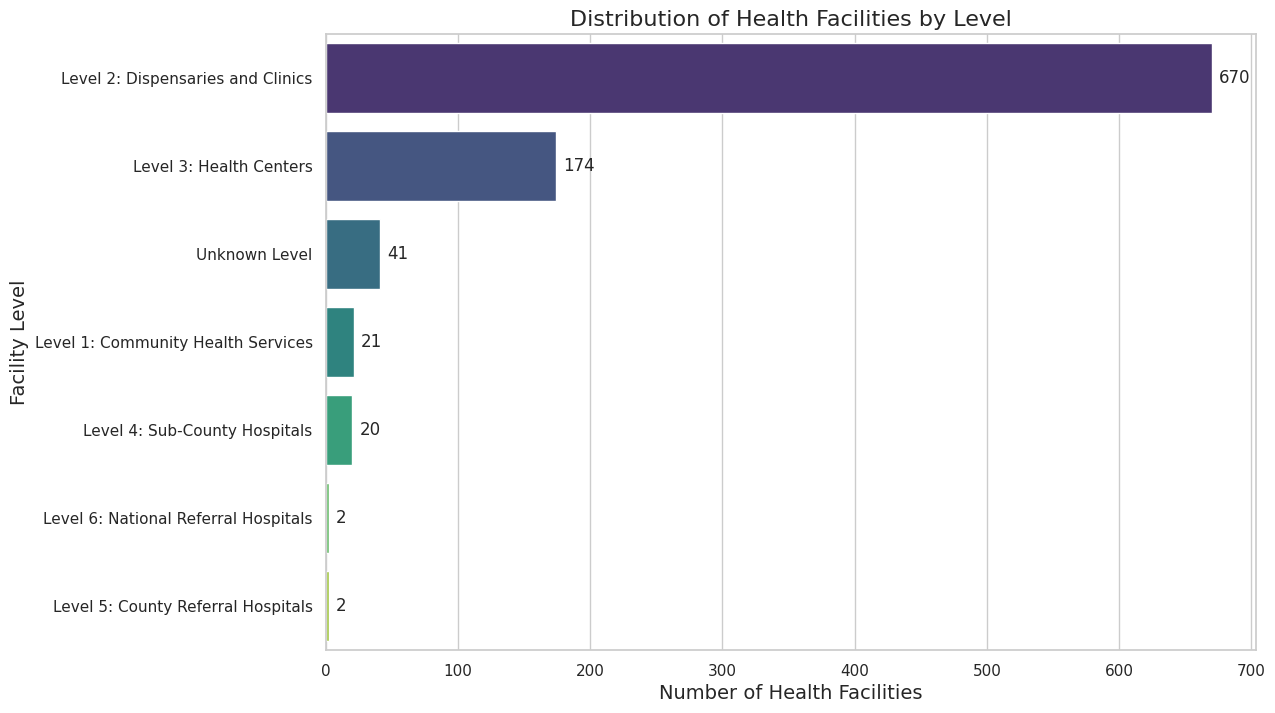

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the bar chart
ax = sns.countplot(y='Facility Level', data=df_healthcare, order=df_healthcare['Facility Level'].value_counts().index, palette="viridis")

# Adding count labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'),
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha = 'left', va = 'center',
                xytext = (5, 0),
                textcoords = 'offset points')

# Adding labels and title
plt.title('Distribution of Health Facilities by Level', fontsize=16)
plt.xlabel('Number of Health Facilities', fontsize=14)
plt.ylabel('Facility Level', fontsize=14)

# Display the plot
plt.show()

### Key Findings
The bar chart indicates that the healthcare system has a strong foundation in **primary and secondary care**, with a substantial number of `Level 2` and `Level 3` hospitals. However, the distribution highlights potential challenges in accessing `highly specialized` and advanced healthcare services due to the `limited number of Level 4 and Level 6 hospitals`, and the complete absence of `Level 5 facilities.` This distribution suggests a need for strategic planning and investment to enhance the availability of advanced medical care, particularly at regional and national referral levels, to ensure comprehensive healthcare coverage for all patients.

## 2. Operational Status of Medical Facilities
The operational status of medical facilities is a critical factor in determining the availability of healthcare services. This section examines the current operational status of healthcare facilities in Nairobi, highlighting how many are fully operational, non-operational, or pending opening.

In [ ]:
df_healthcare['Operational Status'].value_counts()

Operational Status
Operational        917
Not-Operational     19
Pending Opening      6
Name: count, dtype: int64

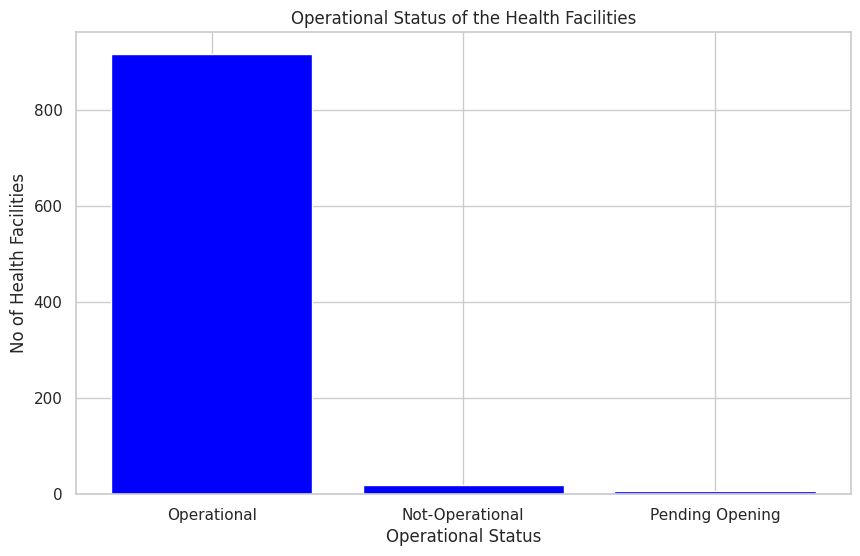

In [ ]:
status_counts = df_healthcare['Operational Status'].value_counts()

# Data to plot
x = status_counts.index
y = status_counts.values

# Create the bar chart
plt.figure(figsize=(10, 6))  # Optional: specify figure size
plt.bar(x, y, color='blue')

# Adding labels and title
plt.xlabel('Operational Status')
plt.ylabel('No of Health Facilities')
plt.title('Operational Status of the Health Facilities')

# Show the plot
plt.show()

Most of the hospitals in Nairobi are operational but

## 3. Ownership of Medical Facilities and Its Impact on Affordability
Ownership of healthcare facilities can significantly influence the affordability and accessibility of healthcare services. This section explores the different ownership types of medical facilities in Nairobi and discusses how ownership affects healthcare costs and accessibility for the population.

In [ ]:
df_healthcare['Owner'].value_counts()

Owner
Private Enterprise (Institution)                   219
Private Practice - General Practitioner            161
Non-Governmental Organizations                     116
Private Practice - Unspecified                      63
Local Authority                                     58
Ministry of Health                                  56
Kenya Episcopal Conference-Catholic Secretariat     49
Private Practice - Nurse / Midwife                  40
Private Practice - Clinical Officer                 39
Private Practice - Medical Specialist               34
Other Faith Based                                   26
Christian Health Association of Kenya               24
Other Public Institution                            13
Community                                           11
Armed Forces                                         9
Parastatal                                           7
Academic (if registered)                             6
Company Medical Service                              3
Stat

In [14]:
owner_mapping = {
    'Kenya Episcopal Conference-Catholic Secretariat': 'Religious Institutions',
    'Christian Health Association of Kenya': 'Religious Institutions',
    'Other Faith Based': 'Religious Institutions',
    'Private Enterprise (Institution)': 'Private Entities',
    'Company Medical Service': 'Private Entities',
    'Private Practice - General Practitioner': 'Private Entities',
    'Private Practice - Unspecified': 'Private Entities',
    'Private Practice - Nurse / Midwife': 'Private Entities',
    'Private Practice - Clinical Officer': 'Private Entities',
    'Private Practice - Medical Specialist': 'Private Entities',
    'Non-Governmental Organizations': 'NGOs',
    'Humanitarian Agencies': 'NGOs',
    'Armed Forces': 'Government Entities',
    'Local Authority': 'Government Entities',
    'Ministry of Health': 'Government Entities',
    'Other Public Institution': 'Government Entities',
    'State Coorporation': 'Government Entities',
    'Academic (if registered)': 'Academic Institutions',
    'Parastatal': 'Other',
    'Community': 'Other',
    'Supreme Council for Kenya Muslims': 'Other'
}

# Create the new column based on the mapping
df_healthcare['Owner Group'] = df_healthcare['Owner'].map(owner_mapping)

# Display the DataFrame
df_healthcare.head()

,Facility Code,Facility Name,Type,Owner,Constituency,Beds,Cots,Official Mobile,Official Email,Job Title of in Charge,Open 24 Hours,Open Weekends,Operational Status,"Common_services(ART,C-IMCI,FP,HBC,IPD)",Owner Group
0,12861,AAR City Centre Clinic,Medical Clinic,Private Enterprise (Institution),STAREHE,0,0,731191077,emutugi@aar.co.ke,Doctor,N,Y,Operational,Y,Private Entities
1,12862,AAR Kariobangi Clinic,Medical Clinic,Private Enterprise (Institution),RUARAKA,0,0,729876092,info@aar.co.ke,Nursing Officer,N,N,Not-Operational,Y,Private Entities
2,12863,AAR Thika Road Clinic,Medical Clinic,Private Enterprise (Institution),ROYSAMBU,0,0,712509222,ckidiga@gmail.com,Medical Superintendant,N,N,Operational,Y,Private Entities
3,12864,Abandoned Child Care,Dispensary,Non-Governmental Organizations,DAGORETTI SOUTH,0,0,712509222,abakoredispensary@yahoo.com,Nursing Officer,N,N,Operational,Y,NGOs
4,12865,Afwan Medical Centre,Nursing Home,Private Enterprise (Institution),KAMUKUNJI,40,4,723937630,afwanmedical@gmail.com,Hospital Director,Y,Y,Operational,Y,Private Entities


<ipython-input-11-3ba2d2303b05>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='Owner Group', data=df_healthcare, order=df_healthcare['Owner Group'].value_counts().index, palette="viridis")


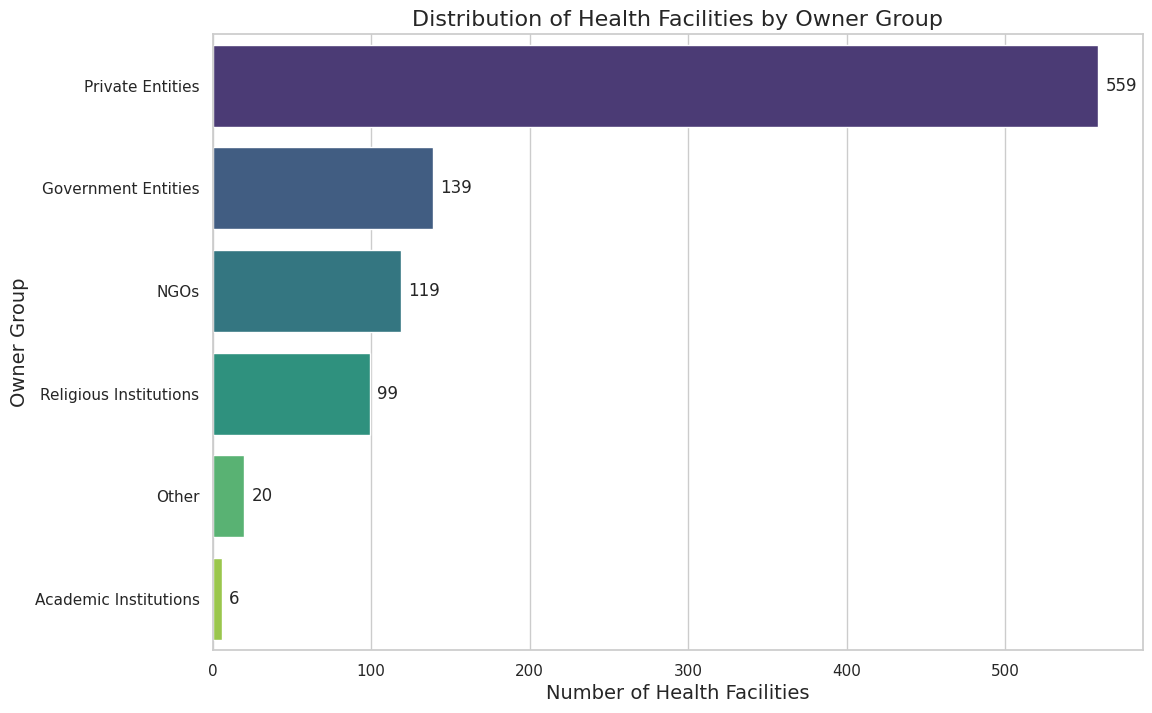

In [ ]:
# Plotting with Seaborn
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")

# Create the bar chart
ax = sns.countplot(y='Owner Group', data=df_healthcare, order=df_healthcare['Owner Group'].value_counts().index, palette="viridis")

for p in ax.patches:
    ax.annotate(format(p.get_width(), '.0f'),
                (p.get_x() + p.get_width(), p.get_y() + p.get_height() / 2),
                ha = 'left', va = 'center',
                xytext = (5, 0),
                textcoords = 'offset points')

# Adding labels and title
plt.title('Distribution of Health Facilities by Owner Group', fontsize=16)
plt.xlabel('Number of Health Facilities', fontsize=14)
plt.ylabel('Owner Group', fontsize=14)

# Display the plot
plt.show()

Healthcare is expensive since most providers are private

Recommendation: Govt needs to up their game

### Key Findings
The bar chart reveals a diverse management landscape of health facilities in Nairobi County, with a pronounced dominance of the private sector. This indicates a healthcare system where private entities are key players, potentially influencing healthcare access, quality, and costs. The significant roles of NGOs and religious organizations highlight their contributions to filling gaps and serving specific populations. This distribution highlights the collaborative nature of healthcare provision across various sectors, each contributing uniquely to the overall healthcare infrastructure.

## 4. Adult and Pediatric Capacity of Medical Facilities
Assessing the capacity of medical facilities to handle adult and pediatric patients is crucial for planning and resource allocation. This section provides an analysis of the bed and cot capacities of healthcare facilities in Nairobi, offering insights into their ability to accommodate patients.

<ipython-input-12-08698b9a34dd>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Owner Group', y='Beds', data=df_healthcare, errorbar=None, palette='viridis', legend=False)


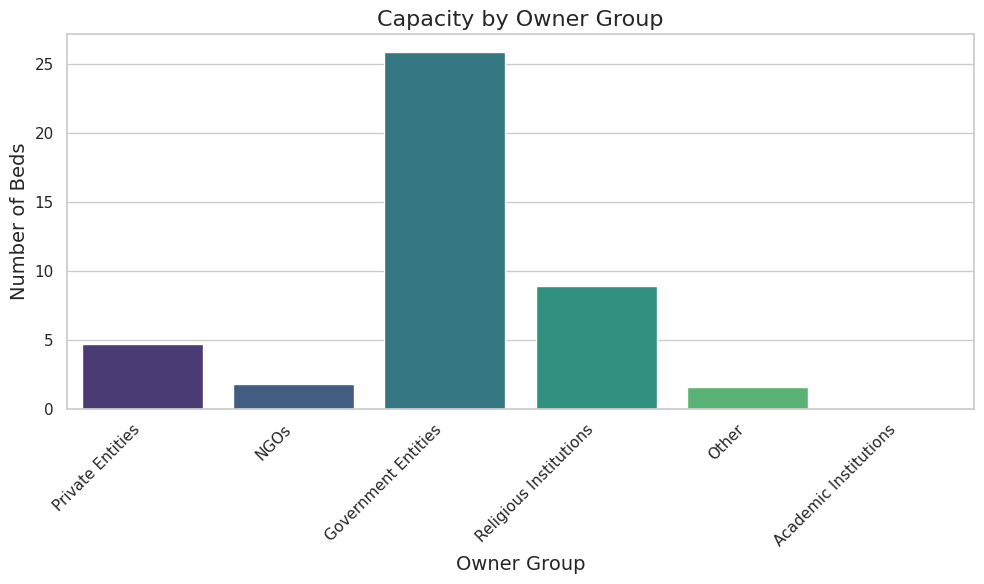

In [ ]:
# Visualization with Column Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Owner Group', y='Beds', data=df_healthcare, errorbar=None, palette='viridis', legend=False)
plt.title('Capacity by Owner Group', fontsize=16)
plt.xlabel('Owner Group', fontsize=14)
plt.ylabel('Number of Beds', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

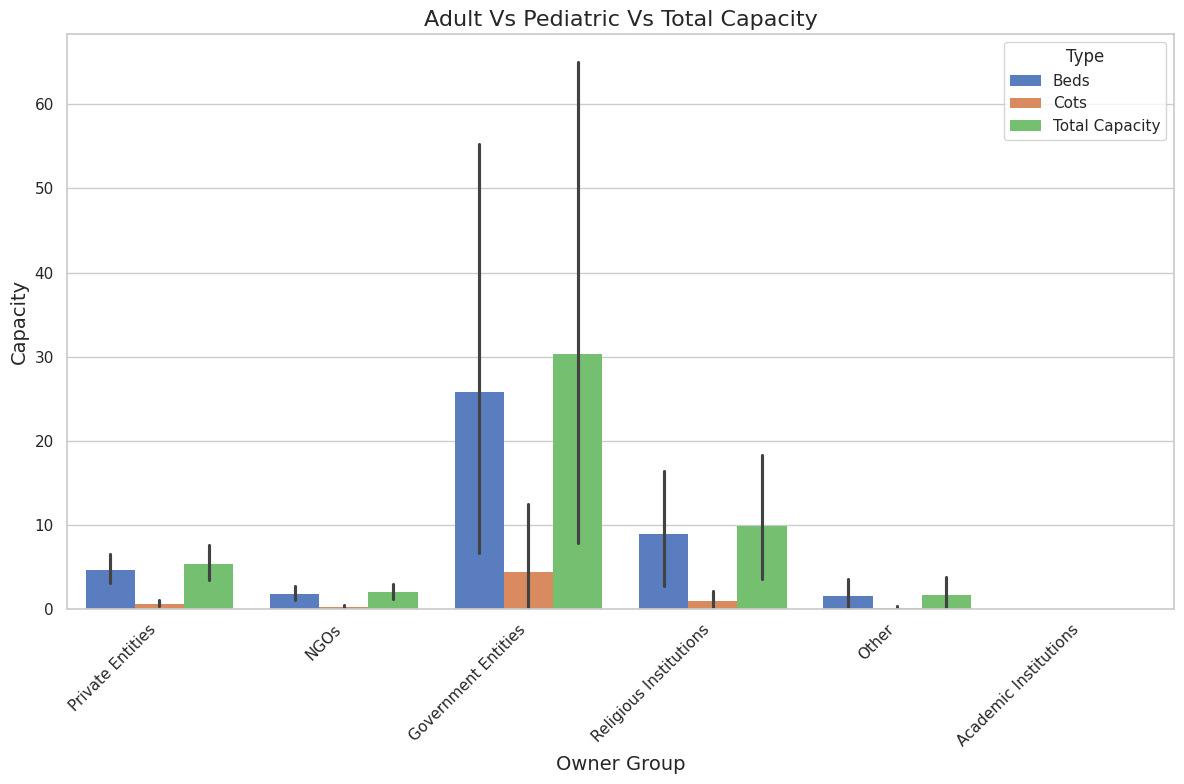

In [ ]:
# Combine the 'Beds' and 'Cots' columns to get the total for each facility
df_healthcare['Total Capacity'] = df_healthcare['Beds'] + df_healthcare['Cots']

# Melt the DataFrame to have separate rows for 'Beds' and 'Cots' for each owner group
df_melted = df_healthcare.melt(id_vars=['Owner Group'], value_vars=['Beds', 'Cots', 'Total Capacity'],
                                var_name='Type', value_name='Number')

# Visualization with Grouped Bar Chart
plt.figure(figsize=(12, 8))

sns.barplot(x='Owner Group', y='Number', hue='Type', data=df_melted, palette='muted', edgecolor='none')

plt.title('Adult Vs Pediatric Vs Total Capacity', fontsize=16)
plt.xlabel('Owner Group', fontsize=14)
plt.ylabel('Capacity', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title='Type')

plt.tight_layout()
plt.show()


### Key Finding
Despite managing only 139 facilities, government hospitals have the highest bed capacity among all ownership types.
This strategic capacity ensures that government hospitals can serve a larger portion of the population, especially during health emergencies and for inpatient care.

## 5. Availability of Services: Operating Hours
The operating hours of medical facilities determine the accessibility of healthcare services. This section examines whether the facilities are open 24/7 or only during specific hours and days, providing insights into the availability of medical services throughout the week.

In [ ]:
df_healthcare['Open 24 Hours'].value_counts()

Open 24 Hours
N    743
Y    199
Name: count, dtype: int64

In [ ]:
df_healthcare.groupby('Owner Group')['Open 24 Hours'].value_counts() #More should be open 24 hrs

Owner Group             Open 24 Hours
Academic Institutions   N                  4
                        Y                  2
Government Entities     N                121
                        Y                 18
NGOs                    N                 98
                        Y                 21
Other                   N                 16
                        Y                  4
Private Entities        N                422
                        Y                137
Religious Institutions  N                 82
                        Y                 17
Name: count, dtype: int64

In [ ]:
df_healthcare.groupby('Owner Group')['Open Weekends'].value_counts()

Owner Group             Open Weekends
Academic Institutions   N                  3
                        Y                  3
Government Entities     N                113
                        Y                 26
NGOs                    N                 68
                        Y                 51
Other                   N                 11
                        Y                  9
Private Entities        Y                389
                        N                170
Religious Institutions  N                 57
                        Y                 42
Name: count, dtype: int64

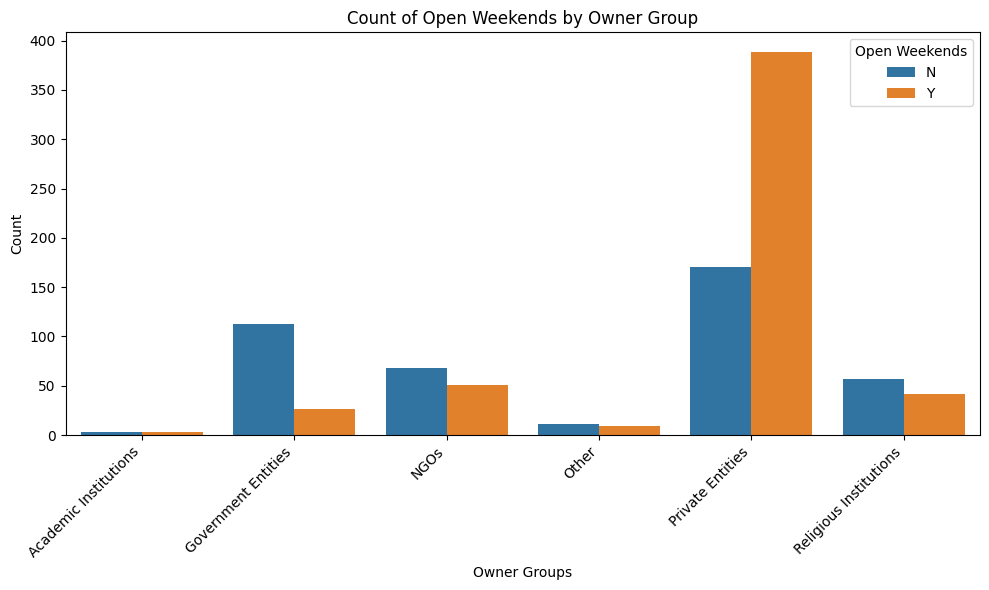

In [16]:
# Grouping and getting the value counts
grouped = df_healthcare.groupby('Owner Group')['Open Weekends'].value_counts().unstack().fillna(0).reset_index()

# Melting the DataFrame to long format
df_melted = grouped.melt(id_vars='Owner Group', value_vars=['N', 'Y'], var_name='Open Weekends', value_name='Count')

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Owner Group', y='Count', hue='Open Weekends', data=df_melted, dodge=True)

# Adding labels and title
plt.xlabel('Owner Groups')
plt.ylabel('Count')
plt.title('Count of Open Weekends by Owner Group')
plt.xticks(rotation=45, ha='right')

# Displaying the plot
plt.tight_layout()
plt.show()

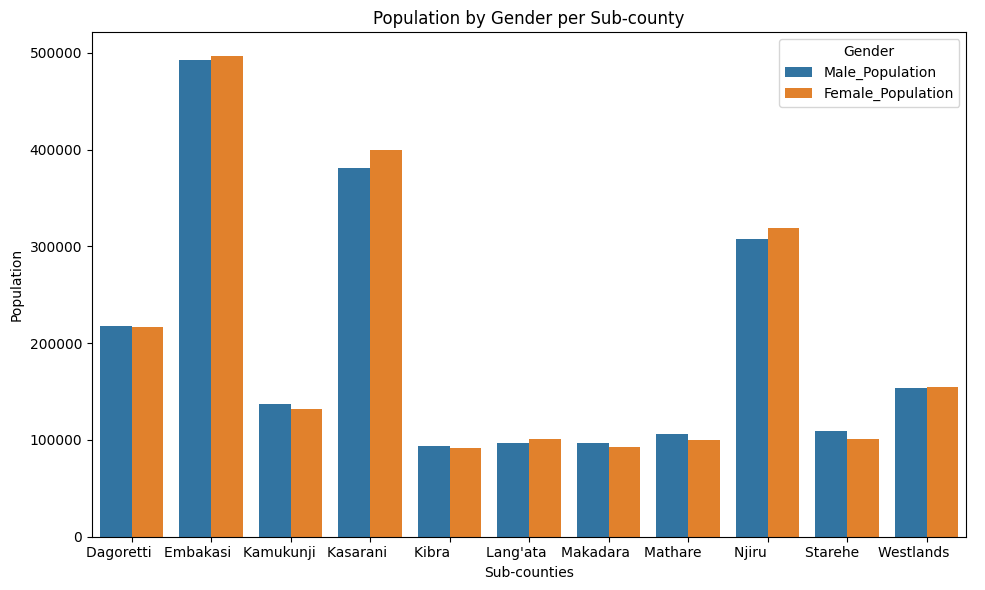

In [4]:
# Melting the DataFrame to long format
df_melted = df_population.melt(id_vars='Name', value_vars=['Male_Population', 'Female_Population'], var_name='Gender', value_name='Population')

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Name', y='Population', hue='Gender', data=df_melted)

# Adding labels and title
plt.xlabel('Sub-counties')
plt.ylabel('Population')
plt.title('Population by Gender per Sub-county')

# Displaying the plot
plt.tight_layout()
plt.show()

### 4. Spatial Distribution of health facilities
Understanding the spatial distribution of health facilities is crucial for effective healthcare planning and resource allocation. It provides insights into how healthcare services are spread across different geographic regions, highlighting areas with adequate access to medical care and identifying potential gaps where healthcare services may be lacking.

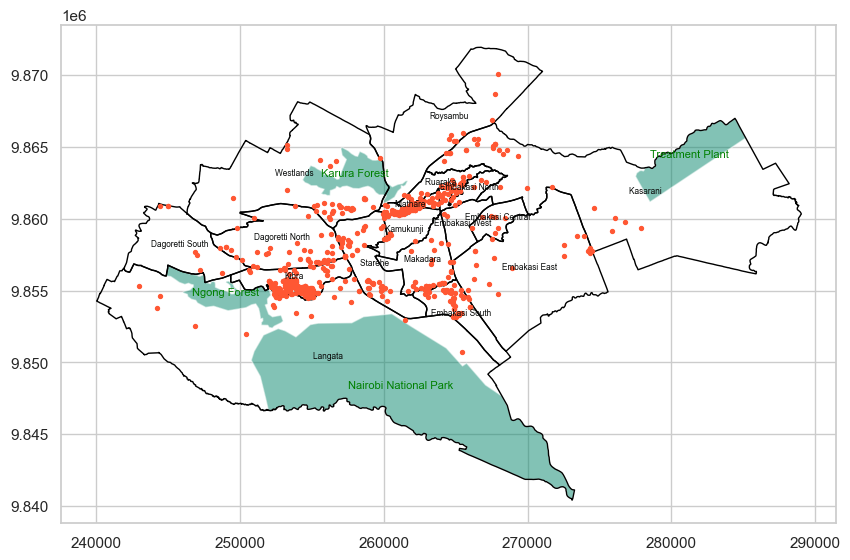

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))

barriers.plot(ax=ax, color='#07876C', alpha = 0.5)
sub_counties.plot(ax=ax, edgecolor='black', facecolor='none')
health_fac.plot(ax=ax, color='#FF5733', markersize=8)

for idx, row in sub_counties.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['subcounty'], xy=(centroid.x, centroid.y), color='#090B0A', fontsize=6, ha='center')

for idx, row in barriers.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['name'], xy=(centroid.x, centroid.y), color='green', fontsize=8, ha='center')

plt.show()

### 5. Number of hospitals in every Sub County

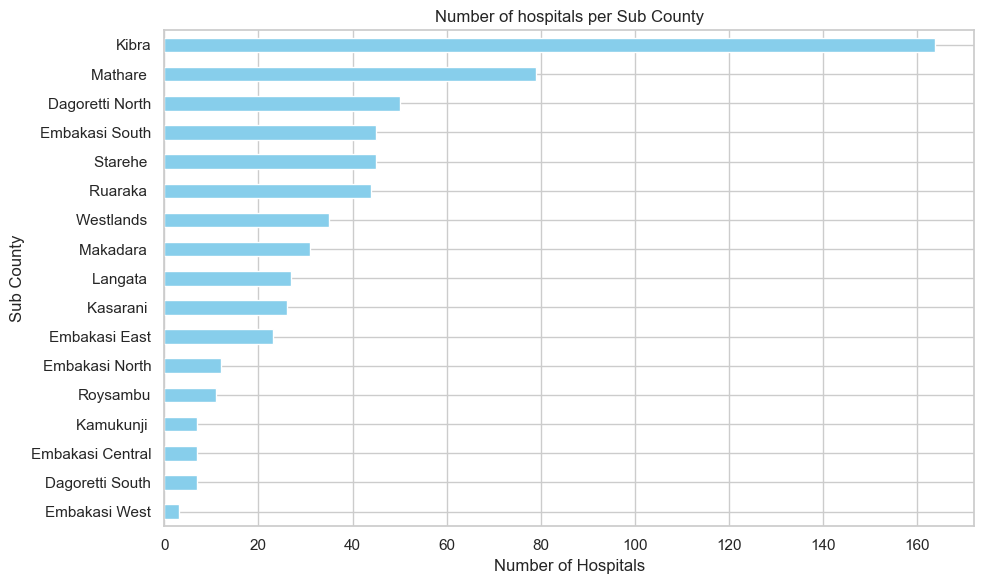

In [ ]:
#Perform Spatial Join to count the number of health facilities within every sub county
health_fac_in_sub_county = gpd.sjoin(health_fac, sub_counties, predicate='within')
point_counts = health_fac_in_sub_county.groupby('subcounty').size().sort_values()

#Plot the results in a bar chart
plt.figure(figsize=(10, 6))
point_counts.plot(kind='barh', color='skyblue')
plt.xlabel('Number of Hospitals')
plt.ylabel('Sub County')
plt.title('Number of hospitals per Sub County')
plt.tight_layout()
plt.show()

### 6. Distance to the nearest hospital
- `Healthcare Accessibility:` It provides a visual representation of healthcare accessibility within Nairobi County, highlighting areas with good access to hospitals and areas that may be underserved.

- `Resource Allocation:` Identifying regions with poor access to hospitals can inform policymakers and healthcare providers where to allocate resources, such as new healthcare facilities or mobile health services, to improve access.

- `Emergency Planning:` During emergencies, quick access to healthcare can be critical. Maps showing distance to hospitals can help in emergency planning and response, ensuring that resources are positioned to maximize response times.

- `Public Awareness:` Such maps can raise awareness among the public and stakeholders about healthcare access issues, potentially driving community action and support for improvements.

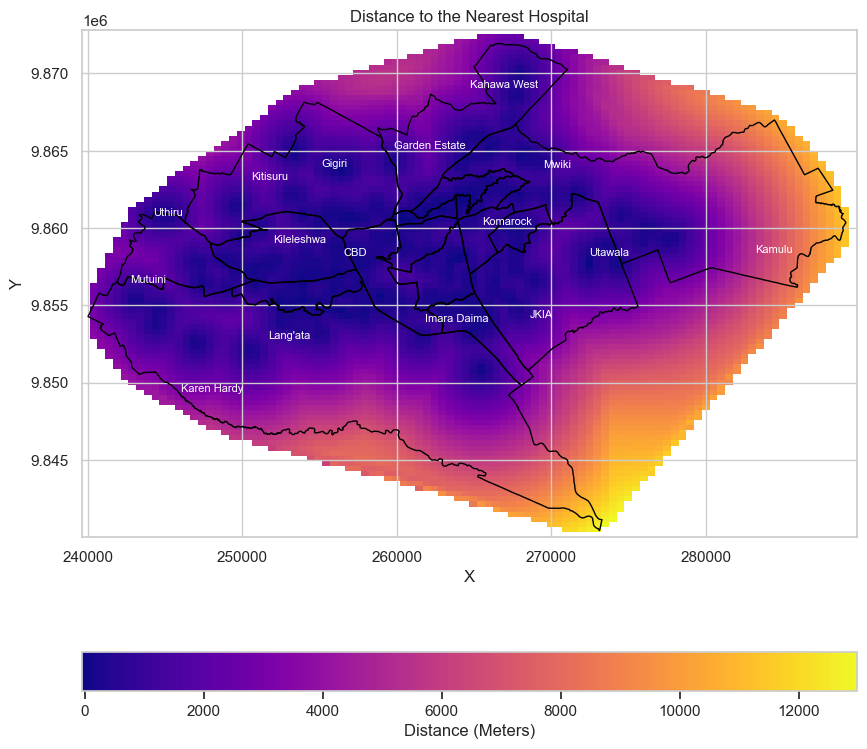

In [ ]:
hospital_coords = list(zip(health_fac.geometry.x, health_fac.geometry.y))
study_area_coords = list(zip(study_area_data.geometry.x, study_area_data.geometry.y))

hospital_kdtree = cKDTree(hospital_coords)

distances, indices = hospital_kdtree.query(study_area_coords, k=1)

# Add distances to every data point
study_area_data['distance_to_nearest_hospital'] = distances


# Extract coordinates and values from the GeoDataFrame
x = study_area_data.geometry.x
y = study_area_data.geometry.y
values = study_area_data['distance_to_nearest_hospital'].values

# Define the grid over which to interpolate
x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), num=100),
                             np.linspace(min(y), max(y), num=100))

# Perform interpolation using inverse distance weighting (IDW)
interpolated_values = griddata((x, y), values, (x_grid, y_grid), method='cubic')

# Plot the interpolated surface
plt.figure(figsize=(10, 10))
plt.imshow(interpolated_values, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='plasma')
sub_counties.plot(ax=plt.gca(), edgecolor='black', facecolor='none')
plt.colorbar(label='Distance (Meters)',orientation='horizontal',location='bottom')

for idx, row in places.iterrows():
    centroid = row.geometry.centroid
    plt.annotate(text=row['name'], xy=(centroid.x, centroid.y), color='white', fontsize=8, ha='center')


plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distance to the Nearest Hospital')
plt.show()

### 7. Available Medical Services

In [22]:
services = {'Prenatal care':'prenatal_care',
            'Dental Service':'dental_services',
            'Home Care':'home_based_care',
            'Malaria':'malaria',
            'Minor Surgery':'minor_surgery',
            'TB Diagnosis':'tb_diagnosis',
            'HIV Counselling':'vct_hiv_counselling_test',
            'Family Planning':'family_planning',
            'Child Care':'management_of_childhood_illness',
            'Nutritional Support':'growth_and_nutritional_support',
            'Inpatient':'inpatient',
            'Outpatient':'outpatient',
            'Sexually Transmitted Infections':'sexually_transmitted_infections_management',
            'Cancer Screening':'medical_service_cancer_screening'
           }

# Create the Dash app
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Medical Services"),

    html.Div([
        dcc.Dropdown(
            id='service-dropdown',
            options=[{'label': name, 'value': name} for name in services.keys()],
            value=list(services.keys())[0]
        )
    ], style={'width': '30%', 'mergin': 'auto','padding': '10px'}),

    html.Div([
        html.Div([
            dcc.Graph(id='map-plot')
        ], style={'width': '50%', 'display': 'inline-block', 'vertical-align': 'top'}),

        html.Div([
            dcc.Graph(id='pie-chart')
        ], style={'width': '45%', 'display': 'inline-block', 'vertical-align': 'top'})
    ], style={'display': 'flex'})
])

@app.callback(
    Output('map-plot', 'figure'),
    Input('service-dropdown', 'value')
)
def update_map(selected_service):
    selected_row = health_fac[health_fac[services[selected_service]] == 'yes']

    fig = px.scatter_mapbox(
        selected_row,
        lat=selected_row['y_coord'],
        lon=selected_row['x_coord'],
        zoom=9,
        hover_name='name'
    )

    fig.update_layout(mapbox_style="carto-positron")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

    return fig

@app.callback(
    Output('pie-chart', 'figure'),
    Input('service-dropdown', 'value')
)
def update_pie_chart(selected_service):
    selected = health_fac[health_fac[services[selected_service]] == 'yes']
    d = {'Category':['Available','Not Available'], 'Values': [len(selected), len(health_fac)-len(selected)]}
    data = pd.DataFrame(d)
    fig = px.pie(data, names='Category', values='Values', title = selected_service)
    return fig

# Run the app
app.run_server(mode='inline')

<IPython.core.display.Javascript object>

### Population by Sub County
Visualizing population by region is a fundamental aspect of understanding demographic patterns and distribution.

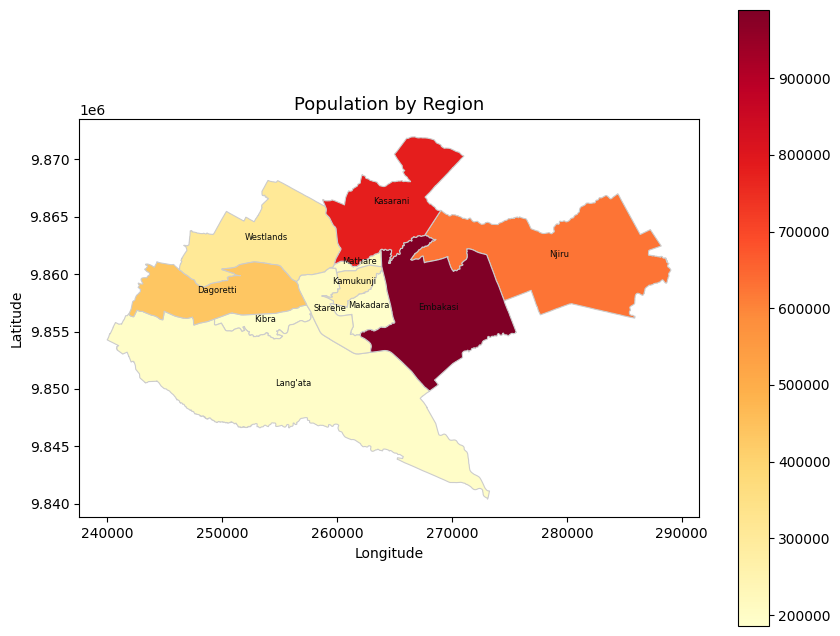

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file('/content/pop.gpkg')

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(column='pop', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add title and labels
plt.title('Population by Region', fontsize=13)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)

for idx, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['subcounty'], xy=(centroid.x, centroid.y), color='#090B0A', fontsize=6, ha='center')

# Show plot
plt.show()

### Population to Hospital Ratio
The population-to-hospital ratio is a critical metric used in healthcare planning and resource allocation. Understanding this ratio provides valuable insights into the adequacy of healthcare infrastructure relative to the size and needs of the population.

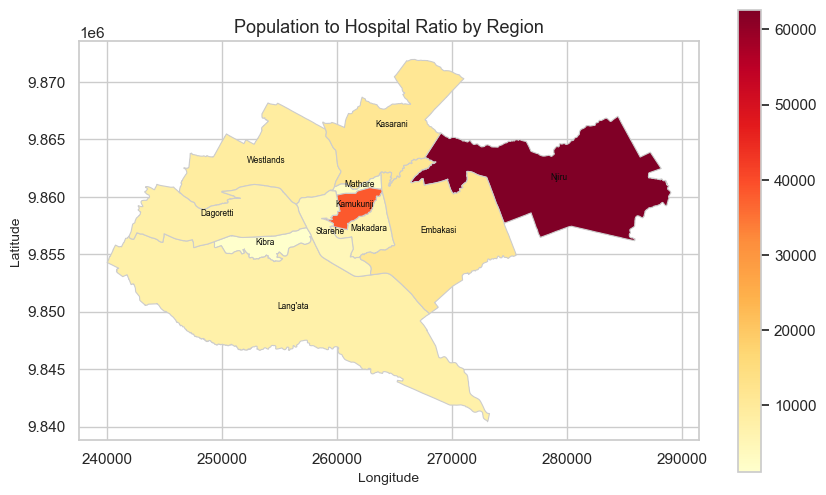

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
gdf.plot(column='ratio', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add title and labels
plt.title('Population to Hospital Ratio by Region', fontsize=13)
plt.xlabel('Longitude', fontsize=10)
plt.ylabel('Latitude', fontsize=10)

for idx, row in gdf.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(text=row['subcounty'], xy=(centroid.x, centroid.y), color='#090B0A', fontsize=6, ha='center')

# Show plot
plt.show()

Based on the insights derived from the data provided,

### Insights
1. **Predominance of Level 2 Hospitals**:
   - There is a high number of Level 2 hospitals, which generally offer limited services compared to higher-level hospitals.

2. **Higher Presence of Private Entities**:
   - Private hospitals outnumber public hospitals, indicating that healthcare access might be costlier due to the prevalence of private entities.

3. **Capacity Distribution**:
   - Government hospitals have higher capacity compared to religious institutions and private hospitals, suggesting they can accommodate more patients.

4. **Adult vs. Pediatric Capacity**:
   - Across the board, the capacity for adult patients surpasses that for pediatric patients, highlighting a potential gap in pediatric healthcare services.

5. **Operating Hours**:
   - Government hospitals have limited weekend operations, whereas private hospitals tend to be more accessible during weekends.

6. **Proximity of Hospitals**:
   - Thirty percent of hospitals are located within five kilometers of their patients, suggesting a reasonable distribution but also implying that 70% are beyond this range.

7. **Population to Hospital Ratio**:
   - The minimum population to hospital ratio stands at 5 kilometers, indicating potential accessibility issues for some populations.

### Recommendations
1. **Enhance Service Offerings at Level 2 Hospitals**:
   - Upgrade the services provided at Level 2 hospitals to reduce the burden on higher-level hospitals and improve overall healthcare quality.

2. **Increase Public Healthcare Investments**:
   - Invest in building more public hospitals or upgrading existing ones to balance the public-private healthcare ratio, ensuring more affordable healthcare options are available.

3. **Expand Capacity in Government Hospitals**:
   - Continue to expand the capacity of government hospitals to accommodate growing healthcare demands, particularly in underserved areas.

4. **Boost Pediatric Healthcare Services**:
   - Increase the capacity and services for pediatric care in both public and private hospitals to address the current shortfall.

5. **Improve Weekend Accessibility of Government Hospitals**:
   - Implement policies to ensure government hospitals operate on weekends or provide extended hours to improve accessibility for patients who cannot visit during weekdays.

6. **Optimize Hospital Locations**:
   - Strategically plan the establishment of new hospitals in underserved areas beyond the five-kilometer radius to ensure equitable healthcare access.

7. **Public-Private Partnerships**:
   - Foster collaborations between public and private sectors to enhance healthcare delivery, including sharing resources and knowledge to improve patient outcomes.

8. **Community Health Outreach**:
   - Develop community outreach programs to educate the public on available healthcare services and preventive care, particularly in areas with fewer hospitals.

9. **Use of Telemedicine**:
   - Promote telemedicine services to bridge the gap in areas where physical access to hospitals is limited, providing remote consultations and follow-ups.

10. **Monitoring and Evaluation**:
    - Implement a robust monitoring and evaluation framework to continuously assess healthcare needs, hospital performance, and patient satisfaction to inform future policies and investments.

By addressing these insights with the recommended actions, the healthcare system in Nairobi can become more equitable, accessible, and capable of meeting the diverse needs of its population.